In [1]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Model

In [2]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)

feature_extractor = Model(inputs=model.input, outputs=model.get_layer('fc2').output)
feature_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
import glob
import random

image_files = glob.glob('./screenshots/*.jpg', recursive=True)
random.shuffle(image_files)
image_files = image_files[:len(image_files)]

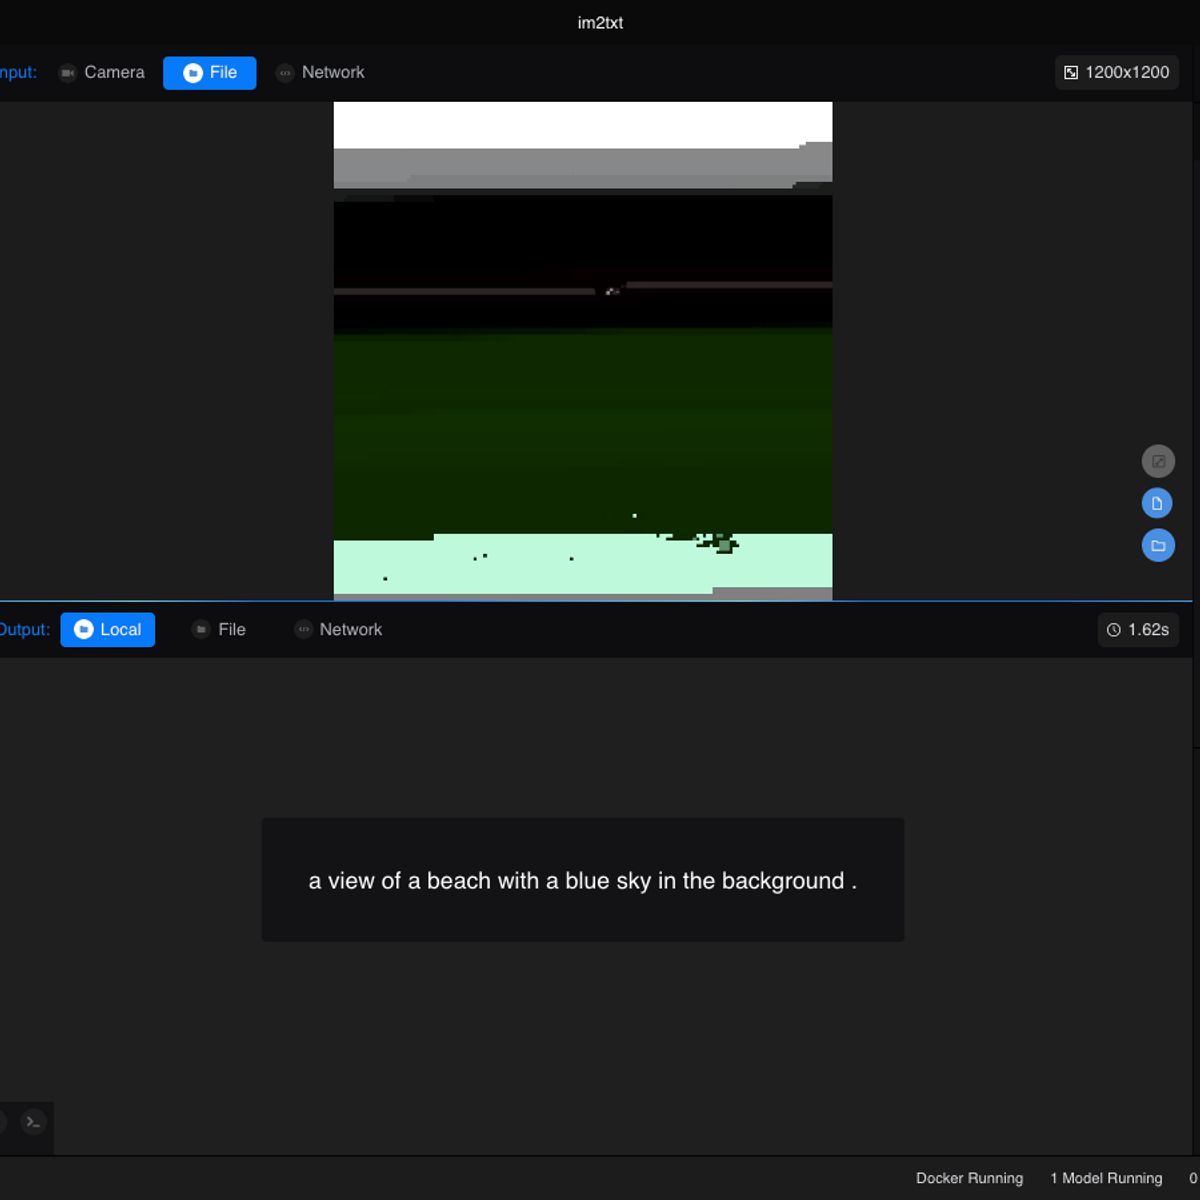

In [7]:
from IPython.display import Image
Image(filename=image_files[random.randint(0, len(image_files))]) 

In [8]:
import numpy as np
features = []

for i, image_path in enumerate(image_files):
    if i % 10 == 0:
        print("analyzed " + str(i) + " out of " + str(len(image_files)))
    img = image.load_img(image_path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feat = feature_extractor.predict(x)[0]
    features.append(feat)

analyzed 0 out of 170
analyzed 10 out of 170
analyzed 20 out of 170
analyzed 30 out of 170
analyzed 40 out of 170
analyzed 50 out of 170
analyzed 60 out of 170
analyzed 70 out of 170
analyzed 80 out of 170
analyzed 90 out of 170
analyzed 100 out of 170
analyzed 110 out of 170
analyzed 120 out of 170
analyzed 130 out of 170
analyzed 140 out of 170
analyzed 150 out of 170
analyzed 160 out of 170


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

ss = StandardScaler()
scaled = ss.fit_transform(features)

In [10]:
kmeans = KMeans(n_clusters=20)
clusters = kmeans.fit_predict(scaled)

In [11]:
clusters

array([ 1,  9,  3,  9,  3, 13,  1,  3,  1,  3,  1,  3,  1,  3,  3,  1,  0,
        6, 15,  9,  1,  1,  9,  1,  3,  2, 12,  3,  3,  1,  1,  1,  3,  3,
        1,  3,  1,  3, 14,  1,  3,  1,  9, 14, 12,  9,  3, 17,  1,  1,  1,
        9,  1,  9,  3,  3,  3, 11,  3,  8,  1,  1, 16,  3, 12,  3, 12,  9,
        3,  9,  3,  1,  1, 12,  3,  3,  3,  1,  3,  9,  3,  4, 14,  3,  2,
        1,  1,  3,  3,  7, 10, 19,  3,  1,  3,  3,  3,  1,  1,  6,  3,  5,
        9,  3,  1,  3,  3,  1,  1,  1,  1,  1,  3,  1,  3,  1,  9, 12,  1,
        2,  1,  4,  1, 12,  4,  3,  3,  1,  1,  1,  1,  1,  3, 12, 10,  3,
        9,  1,  2, 12,  3,  9,  1,  1,  1,  9,  1,  6, 18,  1,  3,  1,  2,
        9,  9,  3,  1,  1,  3,  1,  3, 12,  1, 14,  9,  3, 12,  1,  3,  1],
      dtype=int32)

In [12]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=4, metric='cosine').fit(scaled)
_, closest = neighbors.kneighbors(kmeans.cluster_centers_)
closest

array([[ 16,  80,  32, 163],
       [ 77,   0,  97, 142],
       [152, 138, 119,  25],
       [ 63, 105,   4,  35],
       [124,  81, 121,  86],
       [101,  89,  41,  73],
       [ 17,  99, 147,  93],
       [ 89,  38,  42,  14],
       [ 59, 103,  38, 112],
       [102,  67, 145,   1],
       [ 90, 134, 148, 138],
       [ 57, 155,   5,  11],
       [123, 161,  44,  64],
       [  5,  45,  19,   1],
       [ 82, 163,  43,  38],
       [ 18, 125, 135,  56],
       [ 62,   7,  91,  76],
       [ 47,  95,  62,   9],
       [148,  90, 138, 134],
       [ 91,  62,  84,  89]])

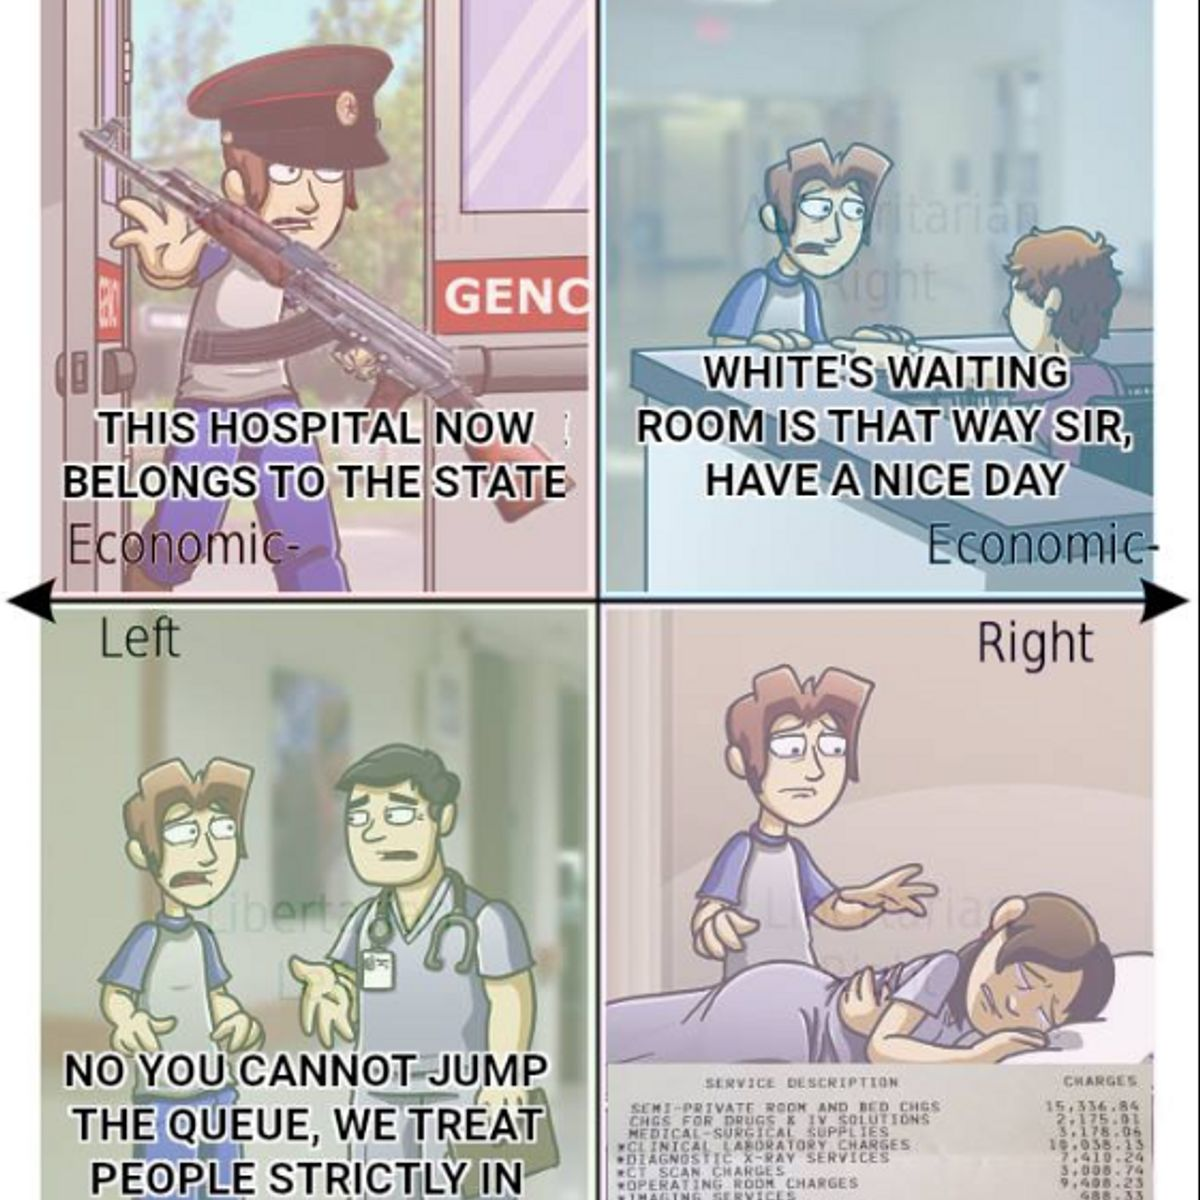

In [17]:
from IPython.display import Image
Image(filename=image_files[100]) 

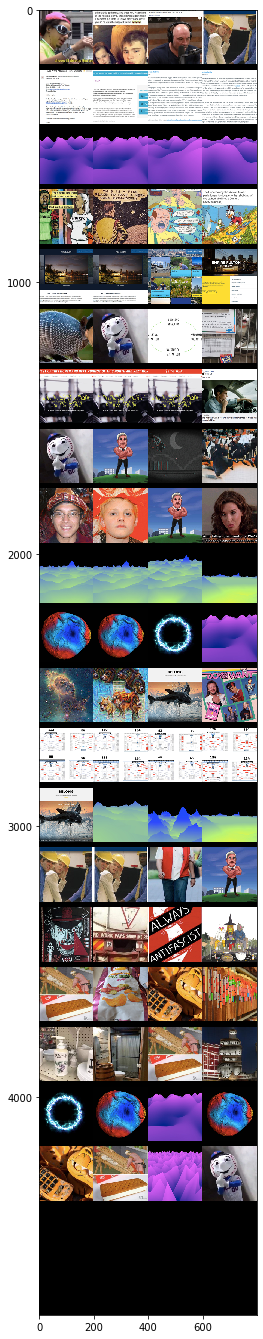

In [19]:
from PIL import Image
import matplotlib.pyplot as plt

img_width = 200
num_neighbors = 4

grid_image = Image.new('RGB', (num_neighbors * img_width, len(closest) * 240), (0, 0, 0, 255))

max_height = 0
for cluster_row in closest:
    max_height_temp = 0
    xpos = 0
    for col_num in cluster_row:
        img = Image.open(image_files[col_num])
        img_ar = img.width / img.height
        img = img.resize((img_width, int(img_width / img_ar)), Image.ANTIALIAS)
        max_height_temp = max(max_height_temp, img.height)
        grid_image.paste(img, (xpos, max_height))
        xpos = xpos + img.width
    max_height = max_height + max_height_temp + 20 # adding 20 pixel margin

plt.figure(figsize = (32,24))
plt.imshow(grid_image)

In [20]:
import umap.umap_ as umap

embedding = umap.UMAP().fit_transform(scaled)

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(embedding)
embedding_scaled = scaler.transform(embedding)

In [22]:
embedding_scaled[0]

array([0.7732349 , 0.17189234], dtype=float32)

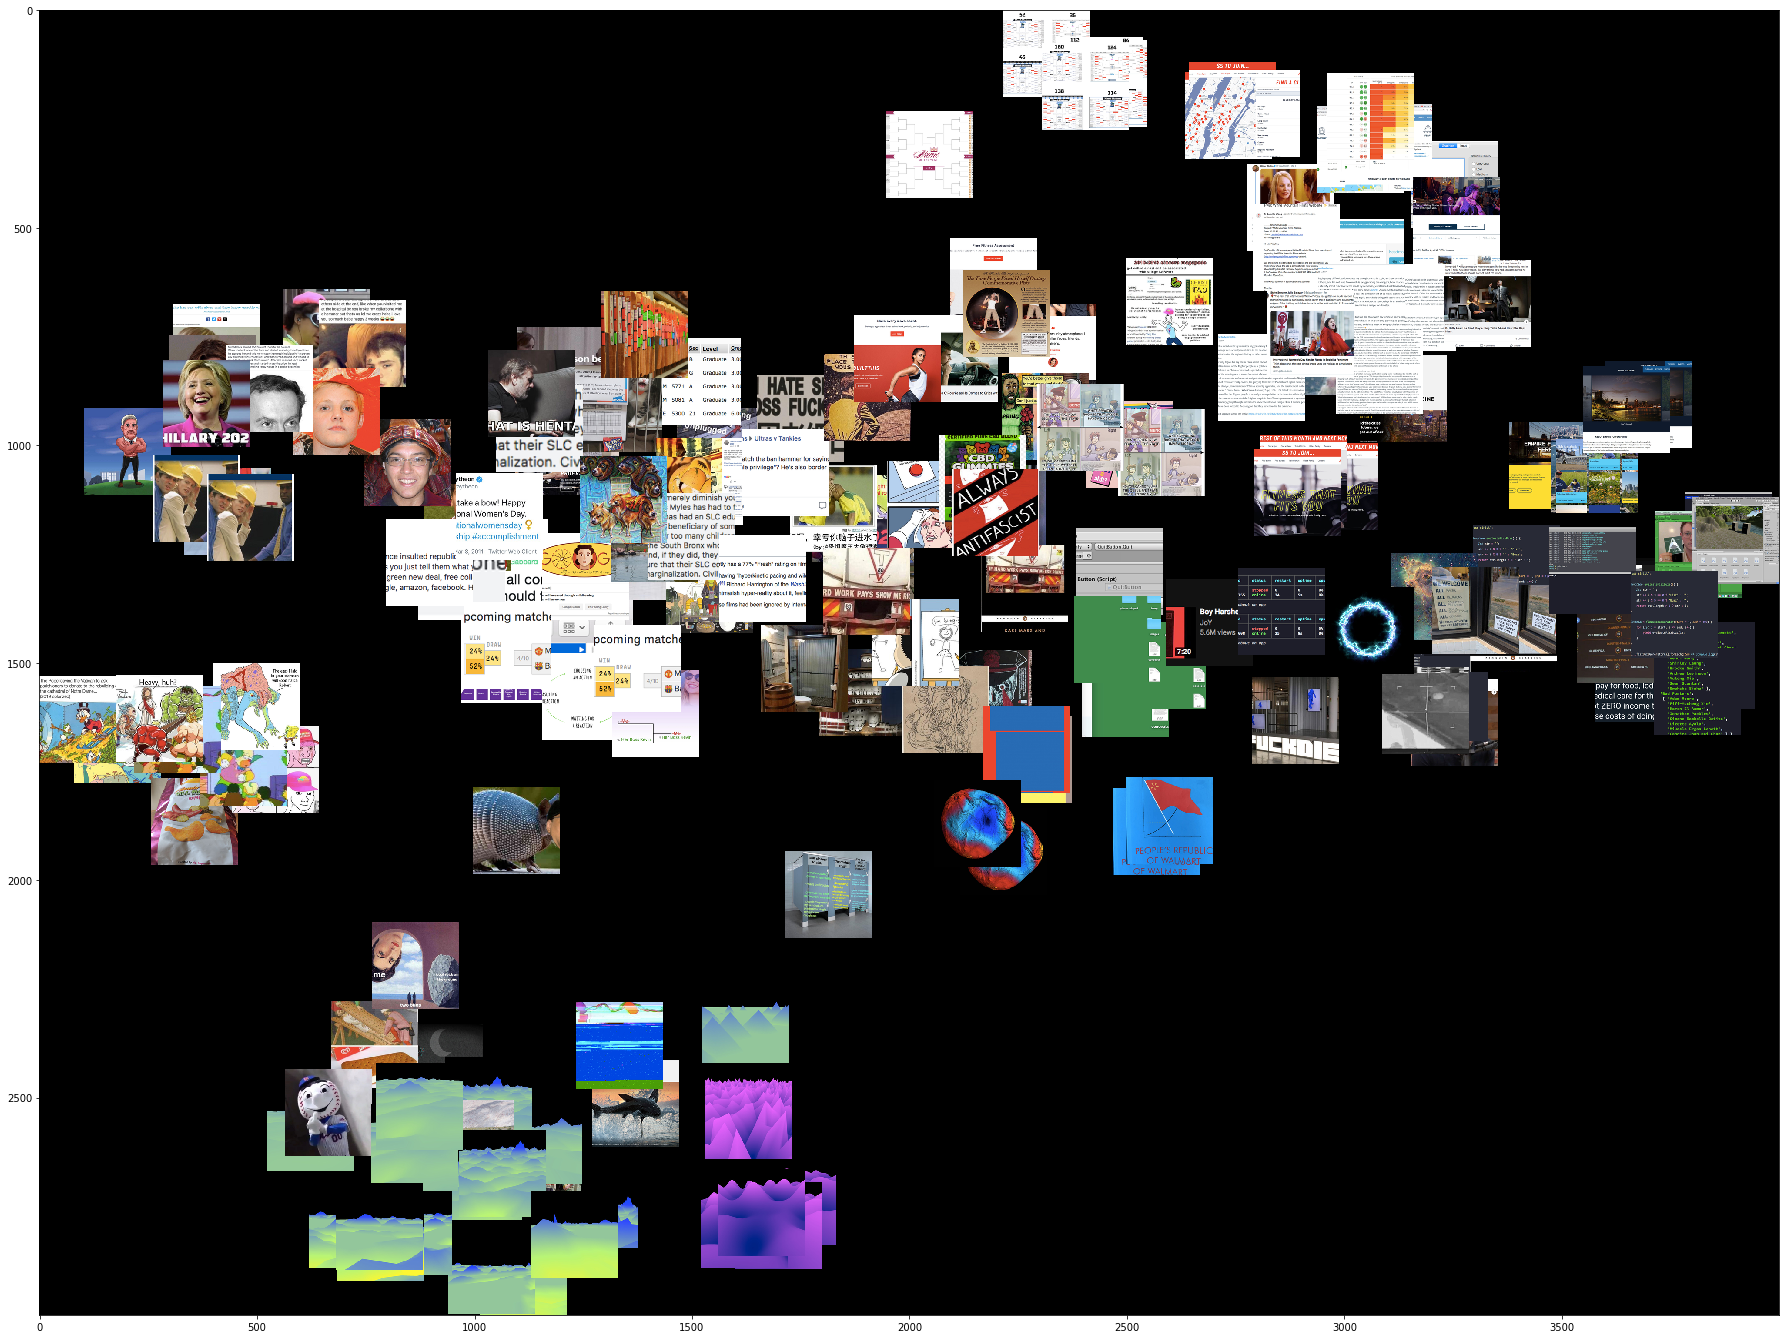

In [23]:
width = 4000
height = 3000
max_dim = 200

full_image = Image.new('RGBA', (width, height), (0, 0, 0, 255))
for img, pos in zip(image_files, embedding_scaled):
    x = pos[0]
    y = pos[1]
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

plt.figure(figsize = (32,24))
plt.imshow(full_image)